# This notebook contains all the top level calls to produce the results and do the testing.

In [1]:
import numpy as np
import pandas as pd

# Importing the core functions: 

## 1. The function 'chain' runs the mcmc chain
## 2. The function 'plot_chain_behaviour' plots the results

In [7]:
from core_mcmc_functions import chain
from core_mcmc_functions import plot_chain_behaviour

In [4]:
# importing the Supernovae data

data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")

# 1A :

## Reproducing Fig S18 for the case with no systematic error and a "uniform" prior over H0 and M. Actually, because there is degeneracy between the HO and M parameters, we keep M fixed at a value -19.23 and only vary H0.


In [31]:
init_state = [.96,.2,50,-19.23] # Choosing an initial state far from the true values
# M must start at the convergence value because it is fixed by the generating function

# Now we set the convergence parameters. 'Convergence' is very tunable here. 
# A 'convergence failure' doesn't mean the algorithm failed so much as
# you set number of trials too low or an unreasonable convergence threshhold/window.

max_trials = 50000 # maximum number of trials

# Defining the convergence window size. Setting this is rather arbitrary but you definitely
# want it to be long so that you don't get stuck at some local minima.Please refer to 
# convergence test function under core_mcmc_functions.py file to understand how this works. 

conv_window = 4000 

# Defining the convergence threshold. Again, this is an arbitrary threshhold. The smaller it 
# is, the tighter you are setting your bound for calling convergence. Even when the chain is 
# converged, your mean over two uncorrelated windows will vary, so if you set this too low,
# then you are basically just waiting for two lucky windows that happen to be very close.

conv_threshold = 0.005 

# Convergence occurs when the mean of the parameters over the previous 4000 steps is within .5%
# of the mean of the 4000 steps before that.

# Running the mcmc chain

chn, rej, convergence = chain(
    data_lcparam,
    max_trials,
    conv_window,
    conv_threshold,
    start_state=init_state,
    gen_variances=None,
    prior_mode="uniform",
)

# For the chain, the default prior function used is the one defined in prior_likelihood.py
# file. The default likelihood function used are the ones defined for the case of only 
# including statistical error. This is why we didn't need to input the prior and likelihood
# functions explicitly for this case. Please refer to the docstrings of the chain function
# to understand the details of this. 

# Also note that we have several hardcoded non-diagonal covariance matrices that we use for the
# generating function. These were estimated using long (50,000+ samples) MCMC chains, and is
# implemented to increase the acceptance ratio of the samples generated by our generating 
# function when we are near the convergence values. We switch b/w these hardcoded covariances
# by passing certain keywords to the gen_variances argument in the chain function.

The chain has converged to the values: [  0.35818737   0.84980313  74.65279954 -19.23      ] in 10038 trials


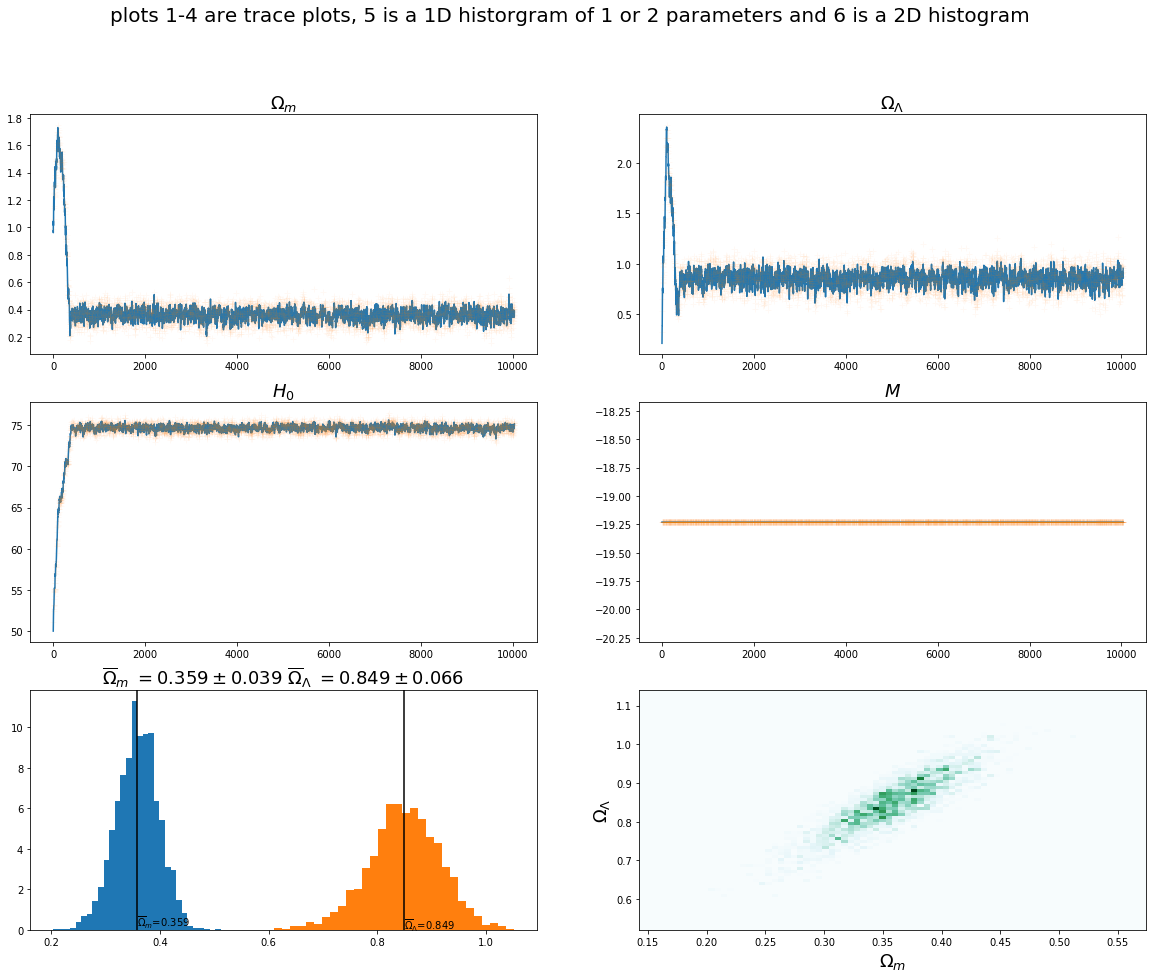

In [32]:
# plotting the results:

plot_chain_behaviour(chn, rej,two_d_bins=80)

# Please refer to the plot_chain_behaviour function under core_mcmc_functions.py to understand the details of
# the plot function.

# 1B :

## Reproducing Fig S18 for the case that includes the systematic error and a "uniform" prior over H0 and M. Actually, because there is degeneracy between the HO and M parameters, we keep M fixed at a value -19.23 and only vary H0

In [9]:
# import systematic error data file

data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

In [10]:
# Importing the likelihood function

from prior_likelihood import log_likelihood

In [11]:
# We will create a likelihood function that uses the systematic error using
# the likelihood function defined in prior_likelihood.py file. To do this we
# will make a new function that calls the likelihood function using the 
# systematic error data.

def sys_error_likelihood(params, data):
    return log_likelihood(params, data, sys_error=sys_error_data)

In [29]:
# Choosing an initial state far from the true values.
# M must start at the convergence value because it is fixed by the generating function

init_state1 = [.96, .2, 50, -19.23] 

max_trials = 50000 # maximum number of trials

# Defining the convergence window size.

conv_window = 6000 

# We choose a higher convergence window for this case otherwise the 2d histogram looks kind of sparse.
# You can check this by changing the conv_window size to 4000. Higher convergence window will mean 
# that the chain takes longer to converge and hence, it will sample the parameter space more. 

# Defining the convergence threshold 

conv_threshold = 0.005 

# Defining the other parameters

kwargs = {'gen_variances' : 'systematic_fix_M', 'prior_mode' : 'uniform', 'likelihood_func' : sys_error_likelihood}

#running the chain

chn, rej, convergence = chain(data_lcparam, max_trials, conv_window, conv_threshold, start_state=init_state1, **kwargs)              

The chain has converged to the values: [  0.32069507   0.73498991  74.11653898 -19.23      ] in 21678 trials


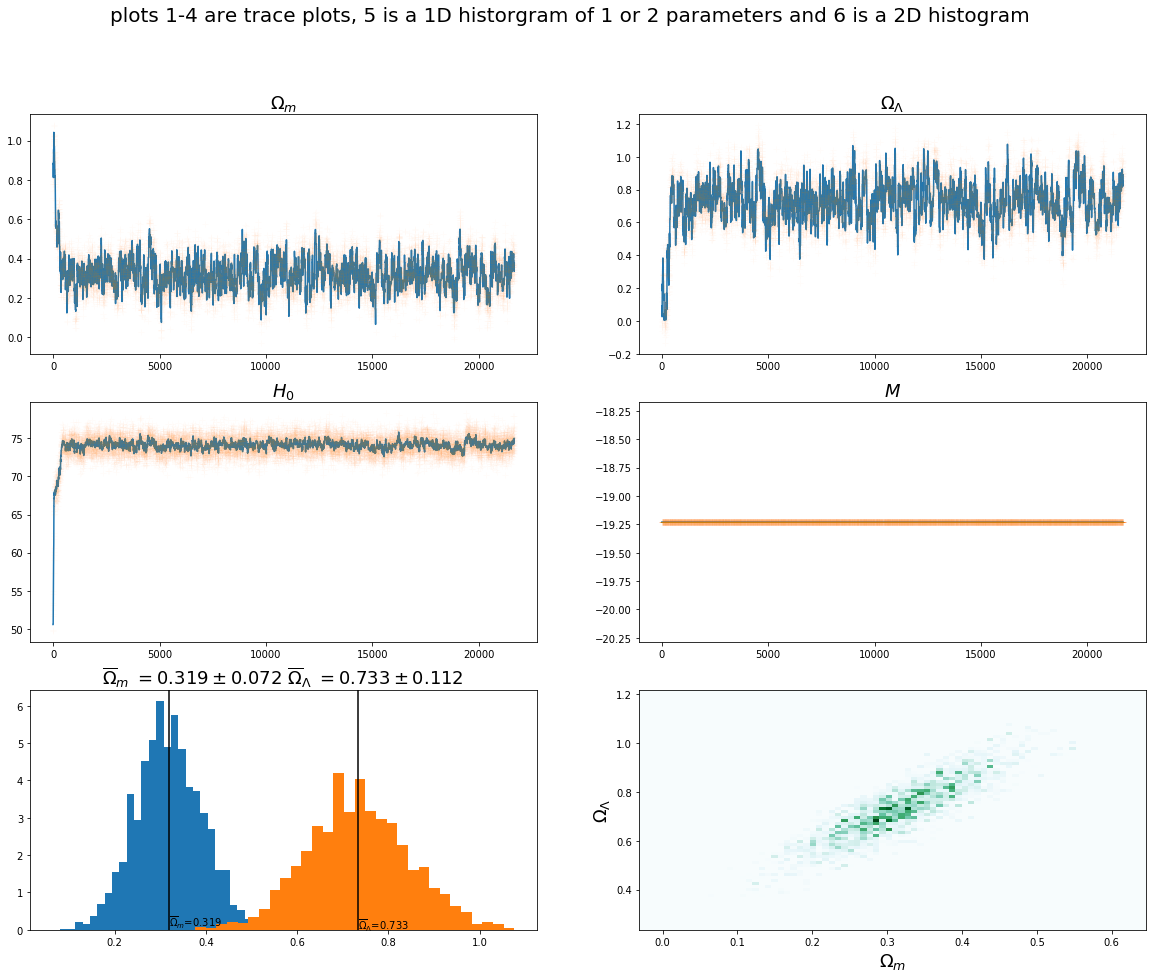

In [30]:
#plot the results:

plot_chain_behaviour(chn, rej,two_d_bins=80)

# 2 :

## Calculate the posterior distribution over H_0 while including the systematic error and having a gaussian prior over M.

In [33]:
# We will start closer to the convergence values here, so it doesnt take too long to run.
# We do not use an adaptive variance, so the process of reaching the convergence region 
# can be slow. Because the systematic error calculations are a lot more computationally
# intense, we choose to start M close to -19.23-- this just makes things run faster without
# having to add adaptive variance. It will take 50,000+ trials to converge if we start at 
# M=-15. The low variance on M means that it can only move so fast as it approaches -19.23.

init_state2 = [.96, .2, 50, -17.5] # Choosing an initial state "far" from the true values

max_trials = 50000 # maximum number of trials

# Defining the convergence window size.

conv_window = 4000 

# Defining the convergence threshold 

conv_threshold = 0.005 

# Defining the other parameters

kwargs = {'gen_variances' : 'systematic', 'prior_mode' : 'M_gaussian', 'likelihood_func' : sys_error_likelihood}

#running the chain

chn, rej, convergence = chain(data_lcparam, max_trials, conv_window, conv_threshold, start_state=init_state2, **kwargs)              

The chain has converged to the values: [  0.31799749   0.74136671  74.16665677 -19.23099214] in 10593 trials


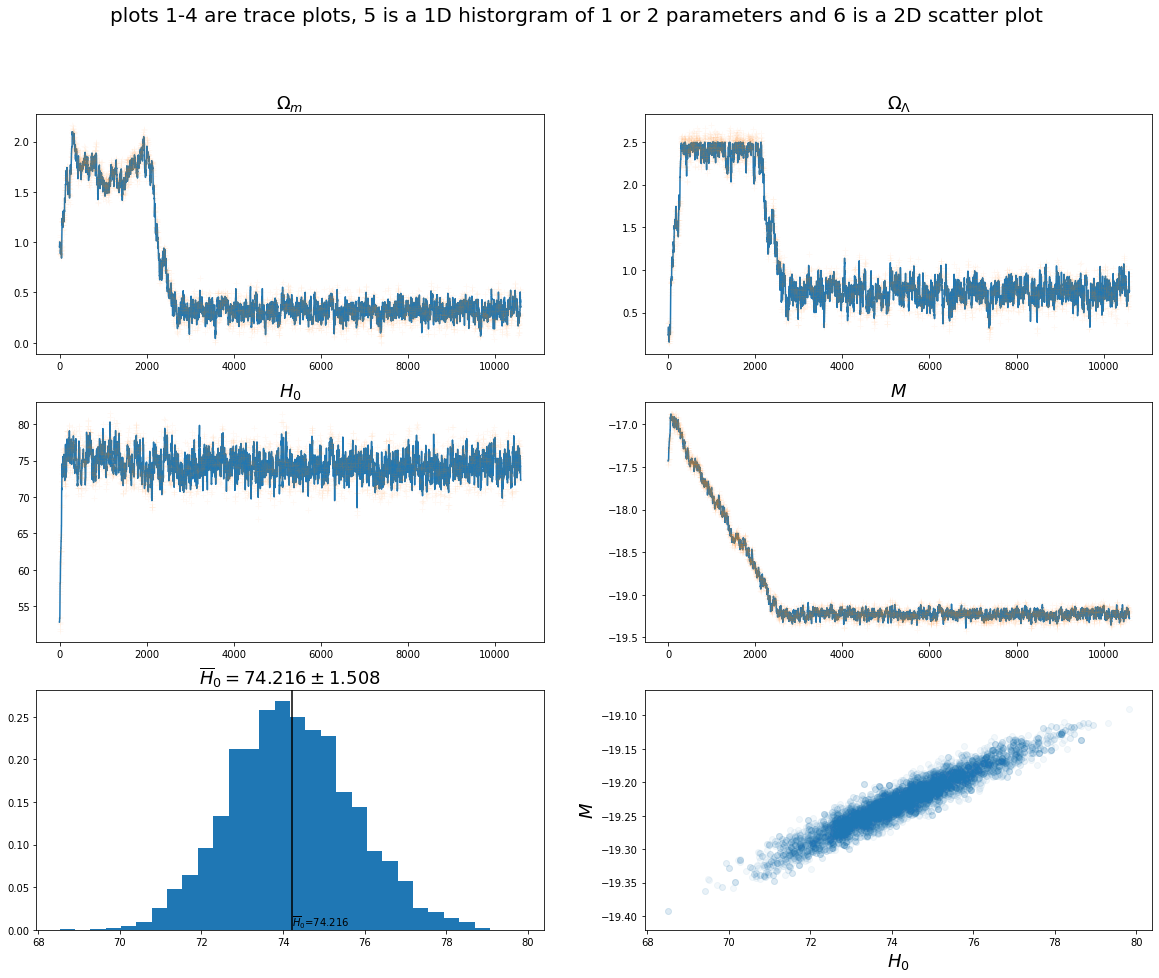

In [34]:
# We need to do is change our plotting parameters from the defaults, so we get a histogram over just H_0.
# The posterior over HO will be in the 5th plot.
# Just for fun, let's play with some other options too : make the last plot a scatter plot of M and H_0.

plot_chain_behaviour(chn, rej, one_d_hist_1=2, one_d_hist_2=None, two_d_hist_1=2, two_d_hist_2=3, two_d_histogram=False)

# Testing

## Here we call all the unit test functions to test our functions.

In [35]:
#Importing all the test functions from test_function.py file.

from test_function import*

In [2]:
# Testing the apparent magnitude calculator function for the cases of Omega_K being zero, positive and negative. 

test_mag_func_omegaK_is_0()
test_mag_func_omegaK_is_neg()
test_mag_func_omegaK_is_pos()

output of the magnitude function is correct
output of the magnitude function is correct
output of the magnitude function is correct


In [3]:
# Testing the apparent magnitude calculator function for the lambda CDM model as we use this model to test
# our mcmc chain function.

test_lambda_cdm_mag_func()

output of the magnitude function for the lambda CDM model is correct


In [4]:
# Testing the log prior function

test_log_prior()

The log prior function works perfectly


In [5]:
# Testing the log prior function for the lambda CDM model as we use this model to test
# our mcmc chain function.

test_lambda_cdm_log_prior()

The Lambda CDM log prior function works perfectly


In [31]:
# Testing the log likelihood function on a fake Supernovae dataset.

log_likelihood_test_fake_data()

Log likelihood function works well on the fake data.


In [36]:
# Testing the function that performs the metropolis-hastings algorithm.

metropolis_test()

'The metropolis function works well.'

In [6]:
# Testing the function that checks the convergence for the mcmc chain

convergence_test_test()

The convergence test functions works well for all the test cases


In [4]:
# Testing the mcmc chain function by comparing the result with the likelihood function

chain_test()

The chain has converged to the values: [  0.38083214   0.82        74.         -19.23      ] in 819 trials
The mcmc chain finds the correct value for Omega_M


In [37]:
# Testing the mcmc chain function by finding the correct Omega_M value for the
# lambda CDM model and comparing it with the result provided in table 8 in
# Scolnic et al 18.

mcmc_lambda_cdm_test()

The chain has converged to the values: [  0.28227672  74.30903787 -19.23      ] in 3516 trials
mcmc chain works perfectly for the lambda cdm model


# The following test is not a unit test but we found it helpful to see if our likelihood function was behaving properly or not.

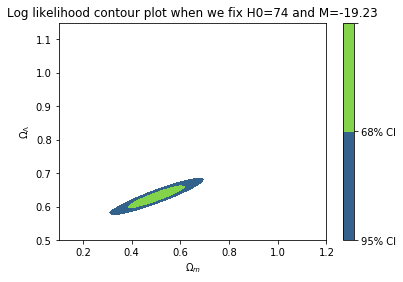

In [2]:
# This test is a little different. It is not a unit test in the sense that it doesn't end with
# an assert statement.It makes the contour plot for the log likelihood function over the 2d 
# parameter space

log_likelihood_test_contour_plot()